In [231]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("../data/gender-classifier-DFE-791531.csv", encoding='latin1')

In [4]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

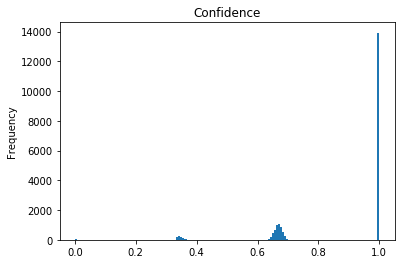

In [5]:
df["gender:confidence"].plot.hist(bins=150);
plt.title("Confidence");

In [6]:
sum(df["gender:confidence"] > 0.99)/df.shape[0]

0.69456359102244392

In [7]:
df[df["gender:confidence"] > 0.99]["gender"].value_counts()

female     5367
male       4653
brand      3784
unknown     122
Name: gender, dtype: int64

In [8]:
chosen_rows = df[df["gender"].isin(["male", "female"]) & (df["gender:confidence"] > 0.99)].index.tolist()

In [9]:
n_samples = len(chosen_rows)
random.shuffle(chosen_rows)
test_size = round(n_samples*0.2)
test_rows = chosen_rows[:test_size]
val_rows = chosen_rows[test_size:2*test_size]
train_rows = chosen_rows[2*test_size:]
len(chosen_rows)

10020

In [209]:
def normalize_text(text):
    # Remove non-ASCII chars.
    text = re.sub('[^\x00-\x7F]+',' ', text)
    
    # Remove URLs
    text = re.sub('https?:\/\/.*[\r\n]*', ' ', text)
    
    # Remove special chars.
    text = re.sub('[?!+%{}:;.,"\'()\[\]_]', '',text)
    
    # Remove double spaces.
    text = re.sub('\s+',' ',text)
    
    return text

In [210]:
df["text_norm"] = [normalize_text(text) for text in df["text"]]

In [211]:
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(df.ix[train_rows, :]["text_norm"])

In [234]:
encoder = LabelEncoder()
X_train = vectorizer.transform(df.ix[train_rows, "text_norm"])
X_val = vectorizer.transform(df.ix[val_rows, "text_norm"])
y_train = encoder.fit_transform(df.ix[train_rows, "gender"])
y_val = encoder.transform(df.ix[val_rows, "gender"])

In [213]:
nb = MultinomialNB()
nb = nb.fit(X_train, y_train)
print(classification_report(y_val, nb.predict(X_val), target_names=encoder.classes_))
accuracy_score(y_val, nb.predict(X_val))

             precision    recall  f1-score   support

     female       0.62      0.81      0.70      1076
       male       0.66      0.42      0.52       928

avg / total       0.64      0.63      0.62      2004



0.63223552894211577

In [195]:
df.head(50)["text"].tolist()

['Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ',
 '\x89ÛÏIt felt like they were my friends and I was living the story with them\x89Û\x9d https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz',
 'i absolutely adore when louis starts the songs it hits me hard but it feels good',
 "Hi @JordanSpieth - Looking at the url - do you use @IFTTT?!  Don't typically see an advanced user on the @PGATOUR! https://t.co/H68ou5PE9L",
 'Watching Neighbours on Sky+ catching up with the Neighbs!! Xxx _Ù÷Ä_Ù÷Ä_Ù÷Ä_ÙÔÎ_Ù\x8fÈ_ÙÔ\x8d_Ù\x8fÈ Xxx',
 'Ive seen people on the train with lamps, chairs, tvs etc  https://t.co/w6zf4pVM4I',
 '@BpackEngineer Thank you for your patience while we take care of the issue!',
 "Gala Bingo clubs bought for å£241m: The UK's largest High Street bingo operator, Gala, is being taken over by\x89Û_ https://t.co/HzeeykJUd3",
 '@_Aphmau_ the pic defines all mcd fangirls/fanboys and mcd shippers xD',
 '@Evielady

In [208]:
df.head(50)["text_norm"].tolist()

['Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries ',
 ' It felt like they were my friends and I was living the story with them ',
 'i absolutely adore when louis starts the songs it hits me hard but it feels good',
 'Hi @JordanSpieth - Looking at the url - do you use @IFTTT?! Dont typically see an advanced user on the @PGATOUR! ',
 'Watching Neighbours on Sky catching up with the Neighbs!! Xxx Xxx',
 'Ive seen people on the train with lamps chairs tvs etc ',
 '@BpackEngineer Thank you for your patience while we take care of the issue!',
 'Gala Bingo clubs bought for 241m The UKs largest High Street bingo operator Gala is being taken over by ',
 '@Aphmau the pic defines all mcd fangirls/fanboys and mcd shippers xD',
 '@Evielady just how lovely is the tree this year! Never seen it as gorgeous as this #Autumn #colour',
 'how are you taking care of yourself? ',
 'MTG Deals 1x Rank-Up-Magic - The Seventh One - PRIO-EN058 - Secret Rare - Unlimi ',
 'Just

In [228]:
logit = LogisticRegression(C=1.0, penalty='l1', tol=1.0e-10)
logit = logit.fit(X_train, y_train)
print(classification_report(y_train, logit.predict(X_train), target_names=encoder.classes_))
print(classification_report(y_val, logit.predict(X_val), target_names=encoder.classes_))
accuracy_score(y_val, logit.predict(X_val))

             precision    recall  f1-score   support

     female       0.78      0.84      0.81      3214
       male       0.80      0.73      0.76      2798

avg / total       0.79      0.79      0.79      6012

             precision    recall  f1-score   support

     female       0.61      0.69      0.65      1076
       male       0.57      0.49      0.53       928

avg / total       0.59      0.59      0.59      2004



0.59481037924151692

In [243]:
svc = SVC()
scaler = StandardScaler()
scaler = scaler.fit(X_train.todense())
X_train = scaler.transform(X_train.todense())
X_val = scaler.transform(X_val.todense())
svc = svc.fit(X_train, y_train)
print(classification_report(y_train, svc.predict(X_train), target_names=encoder.classes_))
print(classification_report(y_val, svc.predict(X_val), target_names=encoder.classes_))
accuracy_score(y_val, svc.predict(X_val))

             precision    recall  f1-score   support

     female       0.89      1.00      0.94      3214
       male       0.99      0.86      0.92      2798

avg / total       0.94      0.93      0.93      6012

             precision    recall  f1-score   support

     female       0.56      0.92      0.70      1076
       male       0.64      0.16      0.25       928

avg / total       0.60      0.57      0.49      2004



0.56886227544910184